# import + functions

import os

In [155]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt  
import json

def make_transition_df(df):
    transitions = []
    in_in_Latency = []
    for index in range(len(df.Port.values)):
        if index < len(df.Port.values)-1:
            transit = int(str(df.Port.values[index]) + str(df.Port.values[index+1]))
            transitions += [transit]
            in_in_diff = df.PokeIn_Time.values[index+1] - df.PokeIn_Time.values[index]
            in_in_Latency += [in_in_diff]
        
 
    transit_df = pd.DataFrame({'Trial_id': df.Trial_id.values[0:-1], 
                                'Transition_type': transitions,
                                'in_in_Latency': in_in_Latency,
                                '2s_Time_Filter_in_in': list((np.array(in_in_Latency) <= 2).astype(int))})
    return transit_df

def get_mean_port_port_transition_latencies(day1_path):
    raw_poke_path = os.path.join(day1_path, np.array(os.listdir(day1_path))[['.csv' in file for file in os.listdir(day1_path)]][0])
    raw_pokes = pd.read_csv(raw_poke_path)
    raw_transits = make_transition_df(raw_pokes)
    mean_port_port_transition_latencies = np.mean(raw_transits['in_in_Latency'].values)
    return mean_port_port_transition_latencies

# main

In [156]:
# pull in the data and calculate deltas
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\"

replay_type = 'sequential_NREM_and_REM_sleep'


In [199]:
os.listdir(data_path)[14]

'EJT269_1_4'

In [212]:
# create dfs to hold the data
predictor_matrix_general_df = pd.DataFrame()
predictor_matrix_motif_df = pd.DataFrame()
outcome_matrix_general_df = pd.DataFrame()
outcome_matrix_motif_df = pd.DataFrame()

for mir in os.listdir(data_path):
    Tracking = False
    Pokes1 = False
    Pokes2 = False
    
    current_path = os.path.join(data_path, mir)
    # only bother loading any of the data if there is replay data saved out. 
    if 'replay' in os.listdir(current_path):#
        print('-------------------------------')
        print(f"Processing {mir}")
        replay_path = os.path.join(current_path, 'replay',replay_type)
        # load replay json 
        json_path = replay_path + r'\replay_data_variables.json'
        with open(json_path, 'r') as file:
            replay_data = json.load(file)
            print(f"Loaded replay data for {mir} from {json_path} ✓ ")
            
        # load in beahvioural data
        for file in os.listdir(current_path):
            if 'day2' in file:
                day2_path = os.path.join(current_path, file)
                # i forgot to do this in the preprocessing, so i added it in here 
                mean_port_port_transition_latencies_2 = get_mean_port_port_transition_latencies(day2_path)
                if 'processed' in os.listdir(day2_path):
                    processed_poke_data_2 = pd.read_csv(os.path.join(day2_path, 'processed', 'processed_poke_data_2.csv'))
                    processed_poke_data_2['transition_times'] = mean_port_port_transition_latencies_2
                    print(f"Loaded poke data 2 for {day2_path} ✓ ")
                    Pokes2 = True
                    try:
                        processed_tracking_data_2 = pd.read_csv(os.path.join(day2_path, 'processed', 'processed_tracking_data.csv'))
                        Tracking = True
                        print(f"Tracking data 2 found for {day2_path} ✓ ")
                    except:
                        print(f"Tracking data not found for {day2_path} ✗")
                        Tracking = False
        for file in os.listdir(current_path):
            if 'day1' in file:
                day1_path = os.path.join(current_path, file)
                # i forgot to do this in the preprocessing, so i added it in here 
                mean_port_port_transition_latencies_1 = get_mean_port_port_transition_latencies(day1_path)
                if 'processed' in os.listdir(day1_path):
                    processed_poke_data_1 = pd.read_csv(os.path.join(day1_path, 'processed', 'processed_poke_data_1.csv'))
                    processed_poke_data_1['transition_times'] = mean_port_port_transition_latencies_1
                    Pokes1 = True
                    print(f"Loaded poke data 1 for {day1_path} ✓ ")
                    try:
                        processed_tracking_data_1 = pd.read_csv(os.path.join(day1_path, 'processed', 'processed_tracking_data.csv'))
                        Tracking = True
                        print(f"Tracking data 1 found for {day1_path} ✓ ")
                    except:
                        print(f"Tracking data not found for {day1_path} ✗")
                        Tracking = False
                        
        if Pokes1 * Pokes2 == True:
            #### Add replay data (predictor) to dataframes
            
            # add all the data to dataframes
            predictor_general_dict = {}
            predictor_general_dict['animal_id'] = mir
            for key, val in replay_data.items():
                if 'motif' not in key:
                    mean_val = np.mean(val) if np.ndim(val) > 0 else val
                    predictor_general_dict.setdefault(key, []).append(mean_val)
                    
            if Tracking:
                predictor_motif_dict = {}
                for key, val in replay_data.items():
                    predictor_motif_dict['animal_id'] = [mir] * len(replay_data['motif_event_rpm'])
                    if 'motif' in key:
                        if np.ndim(replay_data[key][0]) > 0:
                            vals = [np.nanmean(value) for value in replay_data[key]]
                        else:
                            vals = val
                        predictor_motif_dict[key] = vals
                
            #concatenate to DataFrame
            predictor_matrix_general_df = pd.concat([predictor_matrix_general_df, pd.DataFrame(predictor_general_dict)], ignore_index=True)
            if Tracking:
                
                # only keep df rows which appear in the task_relevant_sequences
                task_relevant_sequences = processed_tracking_data_1.sequence_motif.values - 1 
                current_predictor_matrix = pd.DataFrame(predictor_motif_dict)
                current_predictor_matrix = current_predictor_matrix[current_predictor_matrix.index.isin(task_relevant_sequences)]
                current_predictor_matrix['sequence_motif'] = sorted(task_relevant_sequences)
                predictor_matrix_motif_df = pd.concat([predictor_matrix_motif_df, current_predictor_matrix], ignore_index=True)


            #################
            ## calculate behvaioural deltas
            delta_behavioural_data = processed_poke_data_2 - processed_poke_data_1
            if Tracking:
                delta_tracking_data = processed_tracking_data_2 - processed_tracking_data_1
                
            delta_behavioural_data['mouse_id'] = mir
            if Tracking:
                delta_tracking_data['mouse_id'] = [mir] * len(delta_tracking_data)   
                
            # add deltas to dataframes
            outcome_matrix_general_df = pd.concat([outcome_matrix_general_df, delta_behavioural_data], ignore_index=True)
            if Tracking:
                outcome_matrix_motif_df = pd.concat([outcome_matrix_motif_df, delta_tracking_data], ignore_index=True)

 




-------------------------------
Processing EJT136_1_3
Loaded replay data for EJT136_1_3 from Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\replay\sequential_NREM_and_REM_sleep\replay_data_variables.json ✓ 
Loaded poke data 2 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day2_12-11-2021 ✓ 
Tracking data 2 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day2_12-11-2021 ✓ 
Loaded poke data 1 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day1_11-11-2021 ✓ 
Tracking data 1 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day1_11-11-2021 ✓ 
-------------------------------
Processing EJT136_1_4
Loaded replay data for EJT136_1_4 from Z:\projects\sequen

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\1220364679.py:77: RuntimeWarning: Mean of empty slice
  vals = [np.nanmean(value) for value in replay_data[key]]


Loaded replay data for EJT269_1_4 from Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\replay\sequential_NREM_and_REM_sleep\replay_data_variables.json ✓ 
Loaded poke data 2 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day2_19-05-2023 ✓ 
Tracking data not found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day2_19-05-2023 ✗
Loaded poke data 1 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day1_18-05-2023 ✓ 
Tracking data 1 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day1_18-05-2023 ✓ 
-------------------------------
Processing EJT270_1_6
Loaded replay data for EJT270_1_6 from Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_li

# issues:

something is wrong with the way i am setting up the predictor and outcome matricies for the tracking/motifs

I need a better way of accounting for nans (these happen when there is no replay of the motif!) currnelty they are just discounted but they should count! 


# calculate omnibus values 
(weighted average which describes whether how behaviour changed over sessions)

First for the poke data:

In [213]:
# remebr these are deltas
# so if the value is positive, it means the value has increased from day 1 to day 2 

# 1) flip the sign of any columns which are negative in the outcome matrix (eg. higher error rate = lower performance )
negative_columns = ['error_transit_rate', 'neutral_transit_rate', 'transits_per_reward', 'seconds_per_reward']
flipped_outcome_matrix_general_df = outcome_matrix_general_df.copy()
for col in negative_columns:
    if col in flipped_outcome_matrix_general_df.columns:
        flipped_outcome_matrix_general_df[col] = -flipped_outcome_matrix_general_df[col]


# 2) zscore each column in the outcome matrices
zscore_outcome_matrix_general_df = flipped_outcome_matrix_general_df.copy()
# drop the mouse_id column if it exists
zscore_outcome_matrix_general_df = zscore_outcome_matrix_general_df.drop(columns=['mouse_id'])
#apply z-scoring to just those
zscore_outcome_matrix_general_df = zscore_outcome_matrix_general_df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# 3) make a weighted dataframe for each column in the outcome matrix
num_trials_weight = 0 # I think this is probably irrelevant for performance
correct_transit_rate_weight = 1
error_transit_rate_weight = 1 
neutral_transit_rate_weight = 0.2
perf_score_weight = 0.8
total_transitions_weight = 0
transits_per_reward_weight = 0.5
seconds_per_reward_weight = 0.7
transition_times_weight = 1 

# make a weighted vector
weights_vector = np.array([num_trials_weight, correct_transit_rate_weight, error_transit_rate_weight, neutral_transit_rate_weight, perf_score_weight, total_transitions_weight, transits_per_reward_weight, seconds_per_reward_weight, transition_times_weight])

# normalise the weights so they sum to 1
weights_vector_normalised = weights_vector/sum(weights_vector)

# dot product the weights with the z-scored outcome matrix: dot procut is element wise multiplication by weight then summing across the columns
overall_omnibus_deltas_per_animal = zscore_outcome_matrix_general_df.dot(weights_vector_normalised)

omnibus_delta_df = pd.DataFrame({'mouse_id': outcome_matrix_general_df['mouse_id'],
    'overall_delta' : overall_omnibus_deltas_per_animal})
# units are SD units - “SD units” just means you’re expressing a score in multiples of the standard deviation of the distribution - a zscore


now for the tracking/motif data 

In [214]:

# 1) flip the sign of any columns which are negative in the outcome matrix (eg. higher error rate = lower performance )
negative_columns = ['mean_h_distance_from_av_mm', 'std_h_distance_from_av_mm', 'mean_dtw_distance_from_av_mm', 'std_dtw_distance_from_av_mm','std_movement_speed_mm_s']
flipped_outcome_matrix_motif_df = outcome_matrix_motif_df.copy()
for col in negative_columns:
    if col in flipped_outcome_matrix_motif_df.columns:
        flipped_outcome_matrix_motif_df[col] = -flipped_outcome_matrix_motif_df[col]
        
# 2) zscore each column in the outcome matrices
zscore_outcome_matrix_motif_df = flipped_outcome_matrix_motif_df.copy()
# drop the mouse_id column if it exists
zscore_outcome_matrix_motif_df = zscore_outcome_matrix_motif_df.drop(columns=['mouse_id','sequence_motif'])
#apply z-scoring to just those
zscore_outcome_matrix_motif_df = zscore_outcome_matrix_motif_df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# 3) make a weighted dataframe for each column in the outcome matrix
mean_h_distance_from_av_mm = 1 
std_h_distance_from_av_mm = 0.5
mean_dtw_distance_from_av_mm = 0
std_dtw_distance_from_av_mm = 0
mean_movement_speed_mm_s = 1
std_movement_speed_mm_s = 0.2
            
# make a weighted vector
weights_vector = np.array([mean_h_distance_from_av_mm, std_h_distance_from_av_mm, 
    mean_dtw_distance_from_av_mm, std_dtw_distance_from_av_mm, 
    mean_movement_speed_mm_s, std_movement_speed_mm_s
])

# normalise the weights so they sum to 1
weights_vector_normalised = weights_vector/sum(weights_vector)

# dot product the weights with the z-scored outcome matrix: dot procut is element wise multiplication by weight then summing across the columns
overall_omnibus_deltas_per_motif = zscore_outcome_matrix_motif_df.dot(weights_vector_normalised)

omnibus_delta_motifs_df = pd.DataFrame({'mouse_id': outcome_matrix_motif_df['mouse_id'],
    'overall_delta' : overall_omnibus_deltas_per_motif})
# units are SD units - “SD units” just means you’re expressing a score in multiples of the standard deviation of the distribution - a zscore


Text(0, 0.5, 'Omnibus motif deltas (SD units)')

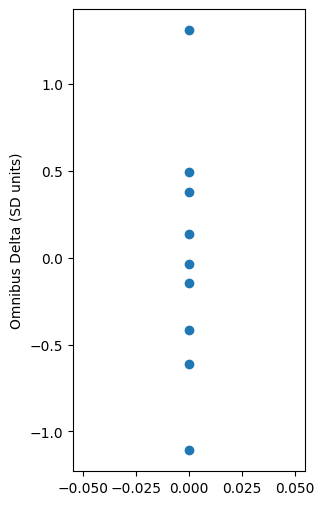

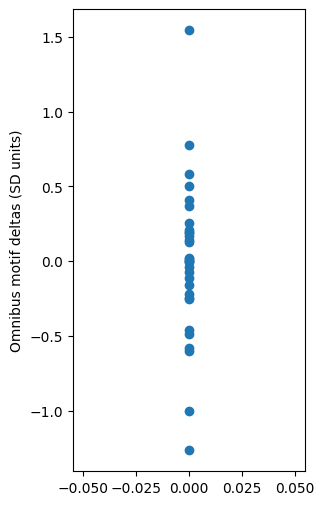

In [215]:

fig, ax = plt.subplots(figsize=(3, 6))
ax.plot(np.zeros(len(omnibus_delta_df.overall_delta.values)),omnibus_delta_df.overall_delta.values,'o')
ax.set_ylabel('Omnibus Delta (SD units)')

fig, ax = plt.subplots(figsize=(3, 6))
ax.plot(np.zeros(len(omnibus_delta_motifs_df.overall_delta.values)),omnibus_delta_motifs_df.overall_delta.values,'o')
ax.set_ylabel('Omnibus motif deltas (SD units)')


In [216]:
## make some basic plots of the omnibus deltas vs predictor variables

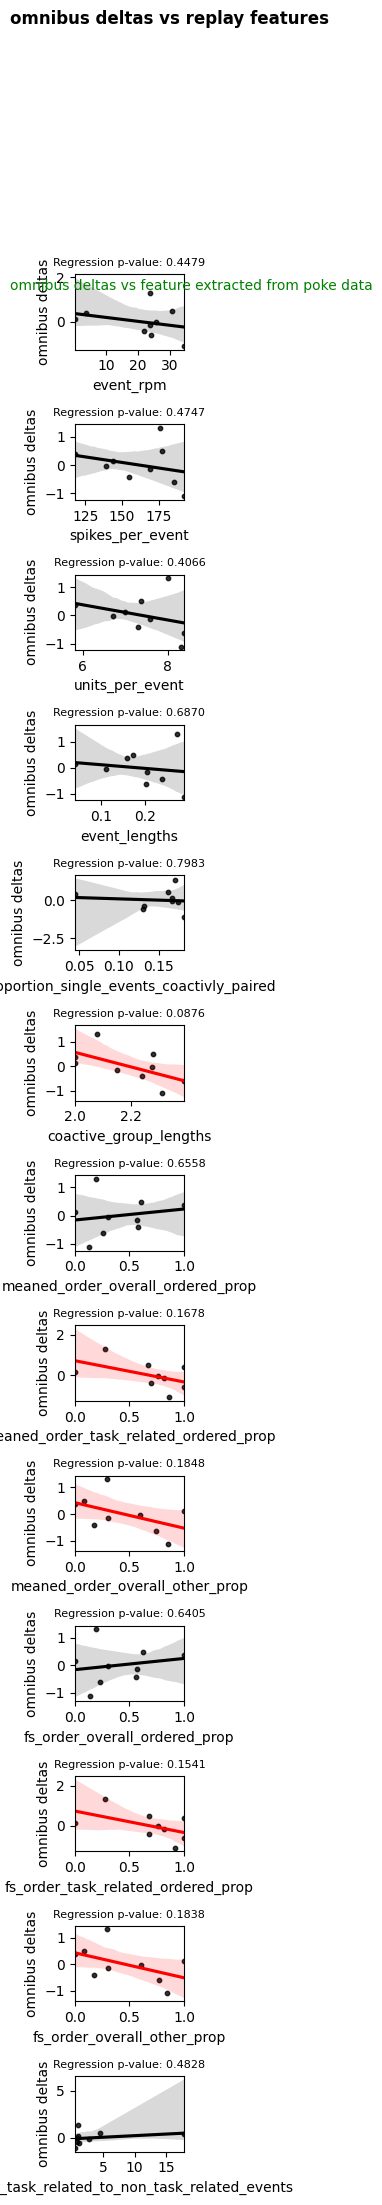

In [226]:
import scipy
import seaborn as sns

def regression_plot(var1, var2, string1, string2,ax):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(var1, var2)
    if p_value < 0.2:
        sns.regplot(x=var1, y=var2, ax=ax, scatter_kws={'color': 'black', 's': 10}, line_kws={'color': 'red'})
    else:
        sns.regplot(x=var1, y=var2, ax=ax, scatter_kws={'color': 'black', 's': 10}, line_kws={'color': 'black'})
    ax.set_xlabel(string1, size = 10)
    ax.set_ylabel(string2, size = 10)
    ax.set_title(f'Regression p-value: {p_value:.4f}', size = 8)    
    
    # Make axis numbers smaller
    ax.tick_params(axis='both', labelsize=10)
    return p_value

def plot_regressions_replay_vs_poke_data(var1,details,y_axis_data,all_mice_behav_vars_dict):
    fig, ax = plt.subplots(len(all_mice_behav_vars_dict.keys()) -1,1,figsize=(2, 20))
    plot_counter = 0
    for key in list(all_mice_behav_vars_dict):
        if not key == 'animal_id':
            regression_plot(all_mice_behav_vars_dict[key],y_axis_data,key,var1,ax[plot_counter])
            plot_counter += 1
    # Add a title above all subplots
    fig.suptitle(f'{var1} vs replay features', fontsize=12, fontweight="bold", x = 0,y = 1.1, ha = 'left')
    # Add a subheading using fig.text()
    fig.text(0, 0.96, f"{details} vs feature extracted from poke data", ha='left', fontsize=10, color = 'green')
    # Adjust layout for better spacing
    plt.tight_layout()  # Adjust bottom spacing
    
     
details = 'omnibus deltas'
y_axis_data = omnibus_delta_df.overall_delta.values
plot_regressions_replay_vs_poke_data(details,details,y_axis_data,predictor_matrix_general_df)

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\676307320.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = predictor_matrix_motif_df.applymap(lambda x: np.nan if isinstance(x, str) else x)


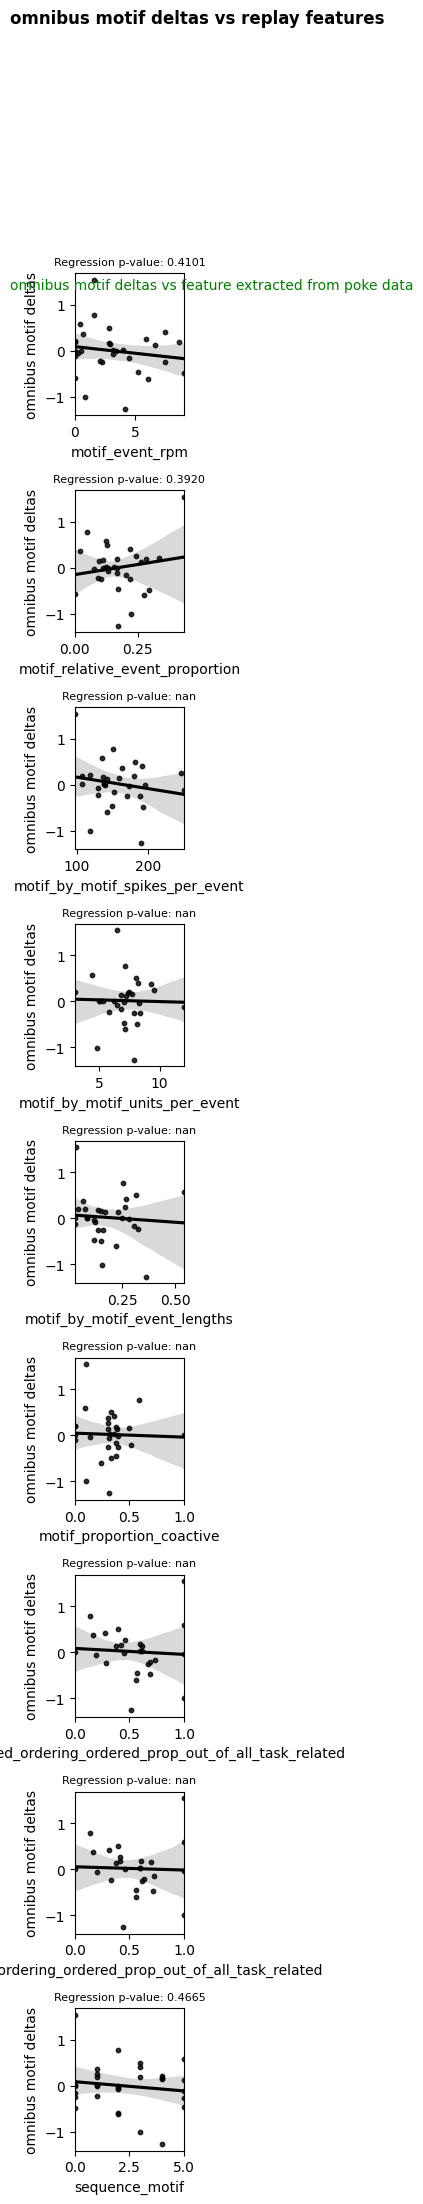

In [233]:
details = 'omnibus motif deltas'
y_axis_data = omnibus_delta_motifs_df.overall_delta.values
df = predictor_matrix_motif_df.applymap(lambda x: np.nan if isinstance(x, str) else x)
plot_regressions_replay_vs_poke_data(details,details,y_axis_data,df)

# what this code does:
It standardizes the predictor matrix X using StandardScaler. It sets up a Ridge regression model with a fixed regularization strength (alpha=0.1). It uses LeaveOneOut cross-validation to estimate the model's performance. For the real data, it fits the model and evaluates its performance by computing the average R² across all cross-validation folds, ignoring any folds that produce undefined R² (due to only one test sample).

Then it performs a permutation test: in each iteration, it shuffles the target variable y to break the relationship between predictors and outcome, fits the Ridge model again using the same cross-validation and scaling, and computes the mean R² from the shuffled data. After all permutations, it compares the real R² to the distribution of shuffled R² values to estimate a p-value, which reflects how likely it is to get the observed predictive performance by chance. A histogram is optionally plotted to visualize this comparison

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\3417183327.py:38: RuntimeWarning: Mean of empty slice
  real_r2 = np.nanmean(real_r2_scores)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\3417183327.py:49: RuntimeWarning: Mean of empty slice
  shuffled_r2s.append(np.nanmean(scores))
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\3417183327.py:49: RuntimeWarning: Mean of empty slice
  shuffled_r2s.append(np.nanmean(scores))
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\3417183327.py:49: RuntimeWarning: Mean of empty slice
  shuffled_r2s.append(np.nanmean(scores))
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\3417183327.py:49: RuntimeWarning: Mean of empty slice
  shuffled_r2s.append(np.nanmean(scores))
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\3417183327.py:49: RuntimeWarning: Mean of empty slice
  shuffled_r2s.append(np.nanmean(scores))
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45604\3417183

Real CV R²: nan
Permutation p-value: 0.0000


c:\miniconda\Lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\miniconda\Lib\site-packages\matplotlib\axes\_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

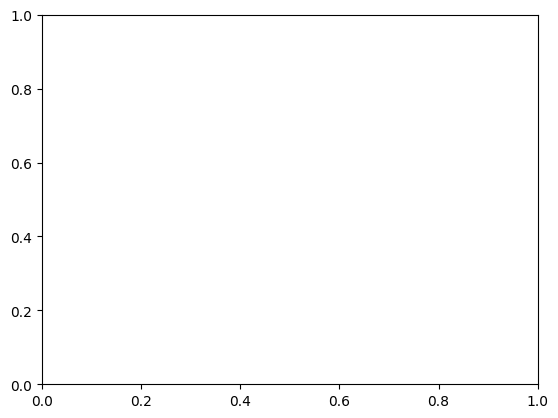

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut, cross_val_score
import matplotlib.pyplot as plt
import warnings

# --- Inputs ---

X_array = predictor_matrix_general_df # shape: (n_samples, n_features)
y_array = omnibus_delta_df.overall_delta.values

# drop some more complex predictor comunns 
X_df = X_array.drop(columns = [ 'proportion_single_events_coactivly_paired',
 'coactive_group_lengths',
 'meaned_order_overall_ordered_prop',
 'meaned_order_task_related_ordered_prop',
 'meaned_order_overall_other_prop',
 'fs_order_overall_ordered_prop',
 'fs_order_task_related_ordered_prop',
 'fs_order_overall_other_prop',
 'Ratio_task_related_to_non_task_related_events'])

# --- Scale predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_array)
y = np.array(y_array)

# --- Model ---
cv = LeaveOneOut()
ridge_model = Ridge(alpha=0.1)

# --- Real R² ---
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    real_r2_scores = cross_val_score(ridge_model, X_scaled, y, cv=cv, scoring='r2')
real_r2 = np.nanmean(real_r2_scores)

# --- Permutation test ---
n_perm = 1000
shuffled_r2s = []

for _ in range(n_perm):
    y_shuffled = np.random.permutation(y)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = cross_val_score(ridge_model, X_scaled, y_shuffled, cv=cv, scoring='r2')
    shuffled_r2s.append(np.nanmean(scores))

# --- p-value ---
p_val = np.mean(np.array(shuffled_r2s) >= real_r2)

# --- Output ---
print(f"Real CV R²: {real_r2:.3f}")
print(f"Permutation p-value: {p_val:.4f}")

# --- Plot ---
plt.hist(shuffled_r2s, bins=30, alpha=0.7, label='Shuffled R²')
plt.axvline(real_r2, color='red', linestyle='--', label=f'Real R² = {real_r2:.3f}')
plt.xlabel('R²'); plt.ylabel('Frequency')
plt.title(f'Permutation Test (LeaveOneOut CV, p = {p_val:.4f})')
plt.legend()
plt.show()



In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LassoCV, RidgeCV
# import numpy as np
# from sklearn.model_selection import LeaveOneOut


# StandardScaler ensures all predictors are on the same scale.
# LassoCV selects the best regularization strength (alpha) using cross-validation.
# Coefficients close to 0 mean that feature was shrunk (possibly not important).
# If you want all features to remain, use RidgeCV instead of LassoCV.


X = predictor_matrix_general_df # shape: (n_samples, n_features)
y = omnibus_delta_df.overall_delta.values


from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeCV

cv = LeaveOneOut()
ridge = RidgeCV(alphas=np.logspace(-4, 2, 50), cv=cv)

ridge.fit(X_scaled, y)
real_r2 = r2_score(y, ridge.predict(X_scaled))






# Normalize X (standard scaling: mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Lasso with cross-validation to choose best alpha
# lasso = RidgeCV(cv=5).fit(X_scaled, y)

cv_setting = min(5, len(y))  # avoids folds with only 1 sample
ridge = RidgeCV(alphas=np.logspace(-4, 2, 50), cv=cv_setting)

# Show results
print("Best alpha:", ridge.alpha_)
print("R² score:", ridge.score(X_scaled, y))

# Coefficients
for name, coef in zip(predictor_matrix_general_df.columns, ridge.coef_):
    print(f"{name}: {coef:.3f}")


AttributeError: 'RidgeCV' object has no attribute 'alphas_'

In [263]:
ridge

RidgeCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.72759372e-0...
       8.68511374e-02, 1.15139540e-01, 1.52641797e-01, 2.02358965e-01,
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
        cv=5)

In [260]:
predictor_matrix_general_df

,event_rpm,spikes_per_event,units_per_event,event_lengths,proportion_single_events_coactivly_paired,coactive_group_lengths,meaned_order_overall_ordered_prop,meaned_order_task_related_ordered_prop,meaned_order_overall_other_prop,fs_order_overall_ordered_prop,fs_order_task_related_ordered_prop,fs_order_overall_other_prop,Ratio_task_related_to_non_task_related_events
0,34.474165,192.193237,8.317230,0.288156,0.181965,2.309735,0.128378,0.863636,0.851351,0.141892,0.913043,0.844595,0.508117
1,23.785714,176.121622,8.009009,0.272384,0.171171,2.078947,0.195122,0.275862,0.292683,0.195122,0.275862,0.292683,1.068571
2,25.660087,138.924166,6.703741,0.112025,0.166835,2.272727,0.304762,0.761905,0.600000,0.300000,0.759036,0.604762,0.937500
3,22.043532,154.452991,7.301994,0.239185,0.131054,2.239130,0.578947,0.702128,0.175439,0.561404,0.680851,0.175439,0.832353
4,30.756495,177.417752,7.358306,0.173785,0.161238,2.277778,0.608696,0.666667,0.086957,0.624506,0.683983,0.086957,4.523077
5,23.720815,169.163265,7.591837,0.203919,0.174927,2.150000,0.565217,0.812500,0.304348,0.565217,0.812500,0.304348,2.798077
6,24.203356,185.111345,8.380252,0.202680,0.130252,2.387097,0.255814,1.000000,0.744186,0.232558,1.000000,0.767442,1.213953
7,0.138032,143.666667,7.000000,0.041417,0.166667,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
8,3.722433,117.855556,5.811111,0.158750,0.044444,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,17.800000


In [255]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import numpy as np

# Fit on real data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # real data
y = omnibus_delta_df.overall_delta.values

# Fit real model
lasso = LassoCV(cv=5).fit(X_scaled, y)
real_r2 = r2_score(y, lasso.predict(X_scaled))

# Permutation test
n_perm = 1000
shuffled_r2s = []

for _ in range(n_perm):
    y_shuffled = np.random.permutation(y)  # shuffle y instead of X
    
    # Use the same scaled X
    lasso_perm = RidgeCV(cv=5).fit(X_scaled, y_shuffled)
    shuffled_r2s.append(r2_score(y_shuffled, lasso_perm.predict(X_scaled)))

# Compare
p_val = np.mean(np.array(shuffled_r2s) >= real_r2)
print(f"Real R²: {real_r2:.3f}, Permutation p-value: {p_val:.4f}")



c:\miniconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.760e-04, tolerance: 3.759e-04
  model = cd_fast.enet_coordinate_descent(
c:\miniconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.424e-04, tolerance: 3.759e-04
  model = cd_fast.enet_coordinate_descent(
c:\miniconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.104e-04, tolerance: 3.759e-04
  model = cd_fast.enet_

Real R²: 0.000, Permutation p-value: 1.0000


c:\miniconda\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\miniconda\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\miniconda\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\miniconda\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\miniconda\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\miniconda\Lib\site-packages\sklearn\metrics\_regressio

In [256]:
real_r2

0.0

In [252]:
print(f"Real R²: {real_r2:.3f}, Permutation p-value: {p_val:.4f}")

Real R²: 0.000, Permutation p-value: 0.9980


In [ ]:
weights_df

,num_trials,correct_transit_rate,error_transit_rate,neutral_transit_rate,perf_score,total_transitions,transits_per_reward,seconds_per_reward,transition_times
0,0.0,0.192308,0.192308,0.038462,0.153846,0.0,0.096154,0.134615,0.192308


In [ ]:
weights_df

,0,correct_transit_rate,error_transit_rate,neutral_transit_rate,num_trials,perf_score,seconds_per_reward,total_transitions,transition_times,transits_per_reward
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
weights_df

,num_trials,correct_transit_rate,error_transit_rate,neutral_transit_rate,perf_score,total_transitions,transits_per_reward,seconds_per_reward,transition_times
0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0


In [ ]:
weighted_outcome_matrix_general_df

,num_trials,correct_transit_rate,error_transit_rate,neutral_transit_rate,perf_score,total_transitions,transits_per_reward,seconds_per_reward,transition_times
0,0.0,-0.942933,1.650122,-0.014397,-1.579911,0.0,0.503443,-1.298539,-1.897505
1,-0.0,1.647524,-1.987837,-0.145713,1.103774,-0.0,-0.941680,0.526573,1.498060
2,0.0,-0.345625,-0.114932,0.132089,0.395123,0.0,-0.005863,-0.171868,-0.188938
3,-0.0,-1.008738,0.274486,0.269113,-0.227177,-0.0,0.172882,0.685965,0.714846
4,0.0,1.110792,-0.356222,-0.286039,0.650635,0.0,-0.302022,-0.645166,-0.562277
5,-0.0,-0.123116,0.112609,0.017747,-0.032638,-0.0,0.095564,-0.084080,-0.205679
6,0.0,-0.859396,0.276189,0.221191,-0.361608,0.0,0.666286,0.660777,0.171801
7,-0.0,0.521493,0.145584,-0.193991,0.051802,-0.0,-0.188609,0.326338,0.469692


In [ ]:
flipped_outcome_matrix_general_df

,num_trials,correct_transit_rate,error_transit_rate,neutral_transit_rate,perf_score,total_transitions,transits_per_reward,seconds_per_reward,transition_times,mouse_id
0,92,-0.080249,-0.075162,-0.005087,-0.286907,1752,-2.116936,6.390712,-0.983713,EJT136_1_3
1,-148,0.109913,0.084754,0.025159,0.145115,-2435,3.423323,-2.684527,0.756373,EJT136_1_4
2,48,-0.036402,0.002426,-0.038827,0.031036,476,-0.164377,0.788421,-0.108143,EJT149_1_1
3,-149,-0.085080,-0.014692,-0.070388,-0.069142,-902,-0.849644,-3.477093,0.355008,EJT178_1_6
4,185,0.070512,0.013032,0.057480,0.072169,1080,0.971027,3.141863,-0.299464,EJT178_1_7
5,-149,-0.020067,-0.007576,-0.012491,-0.037825,-860,-0.553224,0.351901,-0.116723,EJT178_1_8
6,-2,-0.074117,-0.014767,-0.059350,-0.090783,735,-2.741238,-3.351847,0.076720,EJT178_2_1
7,-99,0.027252,-0.009026,0.036278,-0.024232,-1154,0.536228,-1.688874,0.229377,EJT178_2_3


In [ ]:
zscore_outcome_matrix_general_df

,num_trials,correct_transit_rate,error_transit_rate,neutral_transit_rate,perf_score,total_transitions,transits_per_reward,seconds_per_reward,mouse_id
0,0.760181,-0.914441,1.467404,-0.050161,-1.753122,1.236212,1.174380,-1.536257,EJT136_1_3
1,-0.866358,1.456156,-1.635537,-0.717995,1.130541,-1.487770,-1.736360,0.936223,EJT136_1_4
2,0.461982,-0.367828,-0.038072,0.694817,0.369085,0.406071,0.148545,-0.009956,EJT149_1_1
3,-0.873135,-0.974661,0.294076,1.391672,-0.299587,-0.490430,0.508570,1.152152,EJT178_1_6
4,1.390465,0.964978,-0.243877,-1.431645,0.643635,0.799022,-0.447973,-0.651133,EJT178_1_7
5,-0.873135,-0.164204,0.156006,0.113312,-0.090552,-0.463105,0.352838,0.108971,EJT178_1_8


In [ ]:
outcome_matrix_general_df

,num_trials,correct_transit_rate,error_transit_rate,neutral_transit_rate,perf_score,total_transitions,transits_per_reward,seconds_per_reward,mouse_id
0,92,-0.080249,0.075162,0.005087,-0.286907,1752,2.116936,-6.390712,EJT136_1_3
1,-148,0.109913,-0.084754,-0.025159,0.145115,-2435,-3.423323,2.684527,EJT136_1_4
2,48,-0.036402,-0.002426,0.038827,0.031036,476,0.164377,-0.788421,EJT149_1_1
3,-149,-0.085080,0.014692,0.070388,-0.069142,-902,0.849644,3.477093,EJT178_1_6
4,185,0.070512,-0.013032,-0.057480,0.072169,1080,-0.971027,-3.141863,EJT178_1_7
5,-149,-0.020067,0.007576,0.012491,-0.037825,-860,0.553224,-0.351901,EJT178_1_8


In [ ]:
# zscore my deltas.

# weighted average of the deltas




delta_tracking_data

,sequence_motif,mean_h_distance_from_av_mm,std_h_distance_from_av_mm,mean_dtw_distance_from_av_mm,std_dtw_distance_from_av_mm,mean_movement_speed_mm_s,std_movement_speed_mm_s,mouse_id
0,0,0.525667,0.609281,0.409804,0.034668,4.296042,2.551191,EJT178_1_7
1,0,0.410894,0.291842,-0.047228,-0.517722,10.015036,0.490464,EJT178_1_7
2,0,0.080067,0.182667,0.117790,0.087281,9.061283,1.823435,EJT178_1_7
3,0,0.093624,0.095479,-0.086953,0.122308,7.008607,1.098241,EJT178_1_7
4,0,0.660841,0.549272,-0.327533,-0.110235,6.771786,2.699511,EJT178_1_7


In [ ]:
outcome_matrix_general_df

,num_trials,correct_transit_rate,error_transit_rate,neutral_transit_rate,perf_score,total_transitions,transits_per_reward,seconds_per_reward,mouse_id
0,92,-0.080249,0.075162,0.005087,-0.286907,1752,2.116936,-6.390712,EJT136_1_3
1,-148,0.109913,-0.084754,-0.025159,0.145115,-2435,-3.423323,2.684527,EJT136_1_4
2,48,-0.036402,-0.002426,0.038827,0.031036,476,0.164377,-0.788421,EJT149_1_1
3,-149,-0.085080,0.014692,0.070388,-0.069142,-902,0.849644,3.477093,EJT178_1_6
4,185,0.070512,-0.013032,-0.057480,0.072169,1080,-0.971027,-3.141863,EJT178_1_7
5,-149,-0.020067,0.007576,0.012491,-0.037825,-860,0.553224,-0.351901,EJT178_1_8


In [ ]:
#improved behaviour or not? how much has behaviour changed? find a number that indicates this...? 
# increased stereotypy or not? 
# which replay features are associated with improved behaviour?


In [ ]:
# stereotypy is kind of easy from the tracking data
# correct transition rate 

# take the delta of these 
# first plot them against replay features 


In [ ]:
# work out what the next steps are...I need to talk to chat gpt
# essentially I want to know if replay features can predict the behavioural deltas? 
# how do I do a regression with muliple predictors and mulitple outcomes? 
# maybe I cant? Maybe the predictor (replay) variables need to be combined into a single variable? or I need to do a GLM for each? 

In [ ]:
# looks like I want to use a multivariate regression 
# I will use the R squared as a meausre of predictive power of the model, and compare this to shuffled replay features. 

In [ ]:
Y_df

,event_rpm,spikes_per_event,units_per_event,event_lengths
0,34.474165,192.193237,8.317230,0.288156
1,23.785714,176.121622,8.009009,0.272384
2,25.660087,138.924166,6.703741,0.112025
3,22.043532,154.452991,7.301994,0.239185
4,30.756495,177.417752,7.358306,0.173785
5,23.720815,169.163265,7.591837,0.203919


# multivariate regression - do replay features predict behavioural (poke data) deltas?

how well can it predict compared to shuffled versions? 
partial models? getting rid of some features?
which features are the most important 


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.multivariate.multivariate_ols import MultivariateLS

# set up the variable names
Y = predictor_matrix_general_df
X = outcome_matrix_general_df
# drop the mouse_id and animal_id columns as they are not predictors or outcomes
Y_df = Y.drop(columns=['animal_id'])
X_df = X.drop(columns=['mouse_id'])

# drop some of the more complex to interpret columns for now
Y_df = Y_df.drop(columns = list(predictor_matrix_general_df)[5::])
X_df = X_df.drop(columns = ['error_transit_rate','neutral_transit_rate','num_trials'])

#Fit the model
model = MultivariateLS(X_df, sm.add_constant(Y_df)) # X = outcomes, Y = predictors
result = model.fit()

# 4. Summarize
print(result.summary())      # full MultivariateLS table
print(result.params)         # coefficient matrix (exog × endog)
print(result.pvalues)        # p-values per coefficient
print(result.mv_test())      # Wilks’, Pillai, etc. tests

ImportError: cannot import name 'MultivariateLS' from 'statsmodels.multivariate.multivariate_ols' (c:\miniconda\Lib\site-packages\statsmodels\multivariate\multivariate_ols.py)

general regression for inference - is replay predictive? is this prediction significant?

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# set up the variable names
X = predictor_matrix_general_df
Y = outcome_matrix_general_df
# drop the mouse_id and animal_id columns as they are not predictors or outcomes
Y_df = Y.drop(columns=['mouse_id'])
X_df = X.drop(columns=['animal_id'])

# drop some of the more complex to interpret columns for now
X_df = X_df.drop(columns = list(predictor_matrix_general_df)[5::])
Y_df = Y_df.drop(columns = ['error_transit_rate','neutral_transit_rate','num_trials'])


# behavior_names = list(Y.columns)

# STANDARDIZE PREDICTORS
scaler = StandardScaler()
Y_std = scaler.fit_transform(X_df.values)

# 1) MULTIVARIATE TEST (overall inference)
Y_const = sm.add_constant(Y_std)
mv = MANOVA(endog=X_df.values, exog=Y_const)
mv_results = mv.mv_test()
print("=== MANOVA test results ===")
print(mv_results)  # look for the overall p-value under Pillai’s trace / Wilks’ lambda


mv_res = mv.mv_test().results
stat_table = mv_res['x1']['stat']
p_wilks = stat_table.loc["Wilks' lambda", "Pr > F"]
p_pillai = stat_table.loc["Pillai's trace", "Pr > F"]

print("Omnibus p-value (Wilks'):", p_wilks)
print("Omnibus p-value (Pillai):", p_pillai)

=== MANOVA test results ===
                               Multivariate linear model
                                                                                        
----------------------------------------------------------------------------------------
           x0                   Value         Num DF Den DF        F Value        Pr > F
----------------------------------------------------------------------------------------
          Wilks' lambda                0.0000 1.0000 1.0000 6095533867062600.0000 0.0000
         Pillai's trace                1.2612 1.0000 1.0000               -4.8290 1.0000
 Hotelling-Lawley trace 4503599627370495.5000 1.0000 0.5000 2251799813685247.7500 0.0001
    Roy's greatest root 4503599627370495.0000 1.0000 1.0000 4503599627370495.0000 0.0000
----------------------------------------------------------------------------------------
                                                                                        
-------------------------

to what exect does each predictor predict each outcome?

In [ ]:
# multivariate regression - do replay features predict behavioural (tracking data) deltas?
predictor_matrix_motif_df
outcome_matrix_motif_df